Run in Python 3.13.5

- qiskit.__version: 2.1.1  
  
- qiskit_optimization: 0.7.0  
  
- qiskit_ibm_runtime: 0.40.1  
  
- qiskit_finance: 0.4.1  
  
- qiskit_algorithms: 0.4.0  
  
- numpy: 2.3.1  
  
- matplotlib: 3.10.5  


Look at the **requierements.txt**

In [1]:
# pip install -r requirementsMin.txt

## Finance Workshop:  Quantum Portfolio Optimization

Documentation:  
https://quantum.cloud.ibm.com/docs/en/api/qiskit/transpiler 
  
https://qiskit-community.github.io/qiskit-finance/tutorials/01_portfolio_optimization.html   


https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider  

https://qiskit-community.github.io/qiskit-algorithms/tutorials/05_qaoa.html  

https://quantum.cloud.ibm.com/docs/en/api/qiskit/transpiler


In the following link the section of **Execution with V2 Sampler**, which is focused on sending to real Quantum Devices:  
https://qiskit-community.github.io/qiskit-optimization/tutorials/03_minimum_eigen_optimizer.html  


common mistake: https://quantumcomputing.stackexchange.com/questions/38790/valueerror-the-number-of-qubits-of-the-circuit-127-does-not-match-the-number  



In [2]:
import qiskit_optimization, qiskit, qiskit_ibm_runtime, qiskit_finance, qiskit_algorithms, qiskit_aer, numpy, matplotlib
print(f"""
qiskit.__version: 
{qiskit.__version__}
qiskit_optimization:
{qiskit_optimization.__version__}
qiskit_ibm_runtime:
{qiskit_ibm_runtime.__version__}
qiskit_finance:
{qiskit_finance.__version__}
qiskit_algorithms:
{qiskit_algorithms.__version__}
qiskit_aer
{qiskit_aer.__version__}
numpy
{numpy.__version__}
matplotlib
{matplotlib.__version__}
""")


qiskit.__version: 
2.1.1
qiskit_optimization:
0.7.0
qiskit_ibm_runtime:
0.40.1
qiskit_finance:
0.4.1
qiskit_algorithms:
0.4.0
qiskit_aer
0.17.1
numpy
2.3.1
matplotlib
3.10.5



## A Quantum portfolio optimization

This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$
\begin{aligned}
& \min_{x \in \{0,1\}^n} q\, x^T \Sigma x - \mu^T x \\
& \text{subject to: } 1^T x = B
\end{aligned}
$$

where we use the following notation:


- $x \in\{0,1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ( $x[i]=1$ ) and which not to pick ( $x[i]=0)$,
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q>0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications: - all assets have the same price (normalized to 1), - the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x=B$ is mapped to a penalty term $\left(1^T x-B\right)^2$ which is scaled by a parameter and subtracted from the objective function. The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to the optimal solution. This notebook shows how to use the Sampling Variational Quantum Eigensolver (SamplingVQE ) or the Quantum Approximate Optimization Algorithm ( QAOA ) from Qiskit Algorithms to find the optimal solution for a given set of parameters.

In [3]:
# minimal 5-asset QAOA with fixed 5-qubit layout

import datetime
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

# small fake backend + local Sampler
try:
    from qiskit_ibm_runtime.fake_provider import FakeManila  # 5-qubit device
except ImportError:
    from qiskit_ibm_runtime.fake_provider import FakeManilaV2 as FakeManila
    
from qiskit.primitives import BackendSamplerV2
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.result import QuasiDistribution
from qiskit_algorithms import NumPyMinimumEigensolver, SamplingVQE
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# ---- problem (5 assets → 5 qubits) ----
num_assets = 5
seed = 123
stocks = [f"TICKER{i}" for i in range(num_assets)]

data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

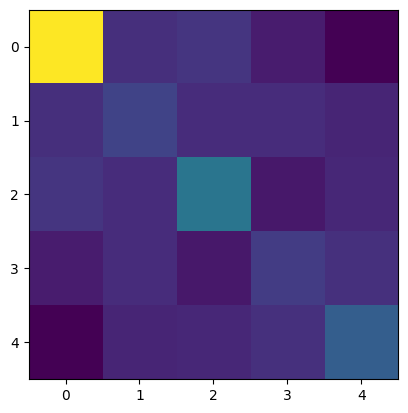

In [5]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [6]:
q = 0.5
budget = num_assets // 2
penalty = num_assets
portfolio=PortfolioOptimization(mu, sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()


In [7]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate

    try:
        probabilities = (
            eigenstate.binary_probabilities()
            if isinstance(eigenstate, QuasiDistribution)
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
    except:
        probabilities = (
            eigenstate.binary_probabilities()
            if isinstance(eigenstate, QuasiDistribution)
            else {k: np.abs(v) ** 2 for k, v in eigenstate.items()}
        )        
    
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    
    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))
    


In [8]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 1.], value -0.0244

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1]	-0.0244		1.0000


In [9]:
# ---- backend + sampler ----
backend = FakeManila()
sampler = BackendSamplerV2(backend=backend)

# build a PassManager for this backend and pin the 4-qubit layout
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
initial_layout = [0, 1, 2, 3, 4]
def transpile_with_layout(circ):
    return pm.run(circ, initial_layout=initial_layout)

# ---- QAOA + solve ----
## Use maxiter to limit the number of iterations on the optimization procedure.
qaoa_mes = QAOA(sampler=sampler, optimizer=COBYLA(maxiter=20), reps=3,
                transpiler=pm)
result = MinimumEigenOptimizer(qaoa_mes, penalty=penalty).solve(qp)

print("Best portfolio (binary x):", result.x)
print("Objective value:", result.fval)



Best portfolio (binary x): [1. 0. 0. 0. 1.]
Objective value: -0.02437876412056923


In [10]:
print(result.prettyprint())

objective function value: -0.02437876412056923
variable values: x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0
status: SUCCESS


In [11]:
print_result(result)

Optimal: selection [1. 0. 0. 0. 1.], value -0.0244

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0]	0.0000		0.0037
[0 0 0 0 1]	-0.0101		0.0018
[1 0 0 0 0]	-0.0140		0.0017
[0 1 0 0 0]	0.0009		0.0017
[1 1 1 1 1]	-0.0242		0.0015
[0 1 1 0 0]	0.0008		0.0015
[0 0 1 0 0]	-0.0001		0.0015
[0 0 1 1 0]	-0.0010		0.0013
[0 0 0 1 0]	-0.0008		0.0013
[0 1 1 0 1]	-0.0092		0.0012
[0 1 0 1 0]	0.0002		0.0011
[0 0 0 1 1]	-0.0107		0.0010
[1 0 0 0 1]	-0.0244		0.0010
[0 1 0 0 1]	-0.0092		0.0010
[0 1 0 1 1]	-0.0098		0.0010
[0 1 1 1 1]	-0.0100		0.0010
[1 1 1 0 0]	-0.0130		0.0010
[0 0 1 1 1]	-0.0110		0.0009
[0 0 1 0 1]	-0.0102		0.0009
[1 1 0 0 0]	-0.0130		0.0007
[1 1 0 1 0]	-0.0139		0.0007
[1 0 0 1 0]	-0.0149		0.0007
[1 0 1 0 0]	-0.0140		0.0006
[1 0 1 0 1]	-0.0244		0.0006
[1 1 1 1 0]	-0.0139		0.0006
[1 1 0 1 1]	-0.0241		0.0006
[1 0 1 1 0]	-0.0150		0.0006
[1 1 0 0 1]	-0.0234		0.0005
[1 1 1 0 1]	-0.0233		0.0005
[0 1 1 

## Sending to the Quantum Computer

In [12]:
#### To retrieve the apikey to access your services from ibm clouds, the token should be consulted from the IBM platfform and changed in the apikey.json file
# import json
# f=open("apikey.json")
# data=json.load(f)
# token=data("apikey")
# service=QiskitRuntimeService(channel="ibm_cloud",token=token)

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerOptions, EstimatorOptions
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
# from qiskit_aer.primitives import SamplerV2
from qiskit_ibm_runtime import SamplerV2
from qiskit_optimization.minimum_eigensolvers import QAOA

from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    OptimizationResultStatus,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
)
from qiskit.visualization import plot_histogram

def get_filtered_samples(
    samples: list[SolutionSample],
    threshold: float = 0,
    allowed_status: tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res


service = QiskitRuntimeService()

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-11 10:01:48,604: Default instance not set. Searching all available instances.


In [14]:
# backend2=service.backend("ibm_brisbane")
backend=service.backend("ibm_torino")

sampler_options= SamplerOptions(default_shots=1024)
sampler_options.dynamical_decoupling.enable=True
sampler_options.dynamical_decoupling.sequence_type='XpXm'
sampler_options.dynamical_decoupling.extra_slack_distribution='middle'
sampler_options.dynamical_decoupling.scheduling_method='alap'

# sampler_options.twirling.enable_gates=True
# sampler_options.twirling.enable_measure=True
# sampler_options.twirling.num_randomizations='auto'
# sampler_options.twirling.shots_per_randomization='auto'
# sampler_options.twirling.strategy='active-accum'

sampler = SamplerV2 (backend, options=sampler_options)

## AerSimulator and SAmplerV2 can be used for simulation.
## Use maxiter inside the COBYLA to limit the number of iterations on the optimization procedure.
## Asume 2 seconds aproximately for each run
## it will consume your cloud quantum computing time.

pass_manager = generate_preset_pass_manager(optimization_level=2, backend=backend)#AerSimulator())
qaoa_noisy = QAOA(
    sampler=sampler,#SamplerV2(seed=123, default_shots=1000),
    optimizer=COBYLA(maxiter=20),
    initial_point=[1, 1],
    pass_manager=pass_manager,
)

meo_noisy = MinimumEigenOptimizer(qaoa_noisy)
qaoa_result = meo_noisy.solve(qp)

objective function value: -0.02437876412056923
variable values: x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0
status: SUCCESS


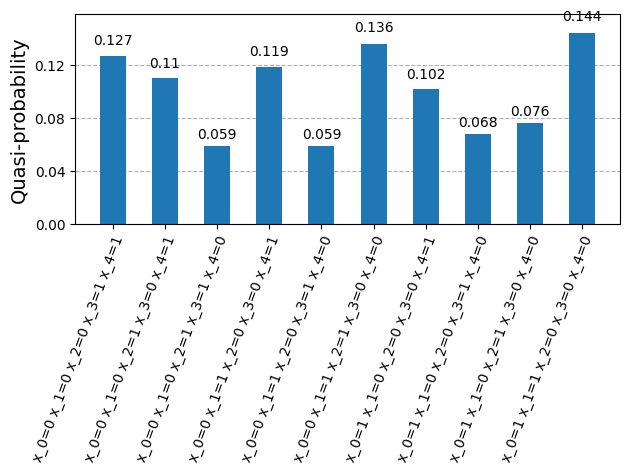

In [15]:
print(qaoa_result.prettyprint())
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.005, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
samples_for_plot = {
    " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in filtered_samples
}

plot_histogram(samples_for_plot,  
               title=f"Real Device Experiment: {backend.name}", 
               filename=f'Real_Device_Experiment_histo_{backend.name}.svg')

plot_histogram(samples_for_plot)